In [1]:
# Install and load necessary libraries for visualization
if (!requireNamespace("pheatmap", quietly = TRUE)) {
  install.packages("pheatmap")
}
if (!requireNamespace("outliers", quietly = TRUE)) {
  install.packages("outliers")
}
# Install and load the 'entropy' package if not already installed
if (!requireNamespace("entropy", quietly = TRUE)) {
  install.packages("entropy")
}
if (!requireNamespace("anomalize", quietly = TRUE)) {
  install.packages("anomalize")
}
if (!requireNamespace("tidyverse", quietly = TRUE)) {
  install.packages("tidyverse")
}
if (!requireNamespace("dbscan", quietly = TRUE)) {
  install.packages("dbscan")
}
library(dbscan)
library(tidyverse)
library(tibbletime)
library(anomalize)
library(timetk)
library(entropy)
library(pheatmap)
library(ggplot2)
library(gridExtra)
library(tsoutliers)
library(keras)
library(reticulate)


Attaching package: ‘dbscan’


The following object is masked from ‘package:stats’:

    as.dendrogram


── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.4     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

Attaching package: ‘tibbletime’


The following object is masked from ‘package:stats’:

    filter



Attaching package: ‘timetk’


The following objects are masked from ‘package:anomalize’:

    anomalize, plot_anomalies



Attaching package: ‘gridExtra’


The following object is masked from ‘package:dplyr’:

    combine


Registered S3 method overwritten by 'quantmo

In [2]:
# Load the dataset
# Spécifier le nombre de lignes à charger (40%)
n_lines_to_load <- round(0.02 * length(readLines("ar41_for_ulb.csv")))

# Charger 40% des lignes du fichier CSV
data <- read.csv("ar41_for_ulb.csv", nrows = n_lines_to_load)
#data <- read.csv("ar41_for_ulb_mini.csv")

In [3]:
# Data Type Conversion
data_split <- strsplit(as.character(data$X.mapped_veh_id.timestamps_UTC.lat.lon.RS_E_InAirTemp_PC1.RS_E_InAirTemp_PC2.RS_E_OilPress_PC1.RS_E_OilPress_PC2.RS_E_RPM_PC1.RS_E_RPM_PC2.RS_E_WatTemp_PC1.RS_E_WatTemp_PC2.RS_T_OilTemp_PC1.RS_T_OilTemp_PC2), ";")
data_df <- as.data.frame(do.call(rbind, data_split))
colnames(data_df) <- c("X","mapped_veh_id", "timestamps_UTC", "lat", "lon", "RS_E_InAirTemp_PC1", "RS_E_InAirTemp_PC2", "RS_E_OilPress_PC1", "RS_E_OilPress_PC2", "RS_E_RPM_PC1", "RS_E_RPM_PC2", "RS_E_WatTemp_PC1", "RS_E_WatTemp_PC2", "RS_T_OilTemp_PC1", "RS_T_OilTemp_PC2")
data_df <- subset(data_df, select = -X)
data_df$mapped_veh_id <- as.factor(data_df$mapped_veh_id)
data_df$timestamps_UTC <- as.POSIXct(data_df$timestamps_UTC, format = "%Y-%m-%d %H:%M:%S")
columns_to_convert <- c("lat", "lon","RS_E_InAirTemp_PC1", "RS_E_InAirTemp_PC2", "RS_E_OilPress_PC1", "RS_E_OilPress_PC2", "RS_E_RPM_PC1", "RS_E_RPM_PC2", "RS_E_WatTemp_PC1", "RS_E_WatTemp_PC2", "RS_T_OilTemp_PC1", "RS_T_OilTemp_PC2")
for (col in columns_to_convert) {
  data_df[, col] <- as.numeric(gsub(",", ".", data_df[, col]))
}

Warning message in (function (..., deparse.level = 1) :
“number of columns of result is not a multiple of vector length (arg 1591)”


In [4]:
# Check for NA values
na_count <- sum(is.na(data_df))
if (na_count > 0) {
  print(paste("There are", na_count, "NA values in the dataset. Handle them appropriately."))
}
# Remove duplicate rows
data_df <- data_df[!duplicated(data_df), ]

[1] "There are 908 NA values in the dataset. Handle them appropriately."


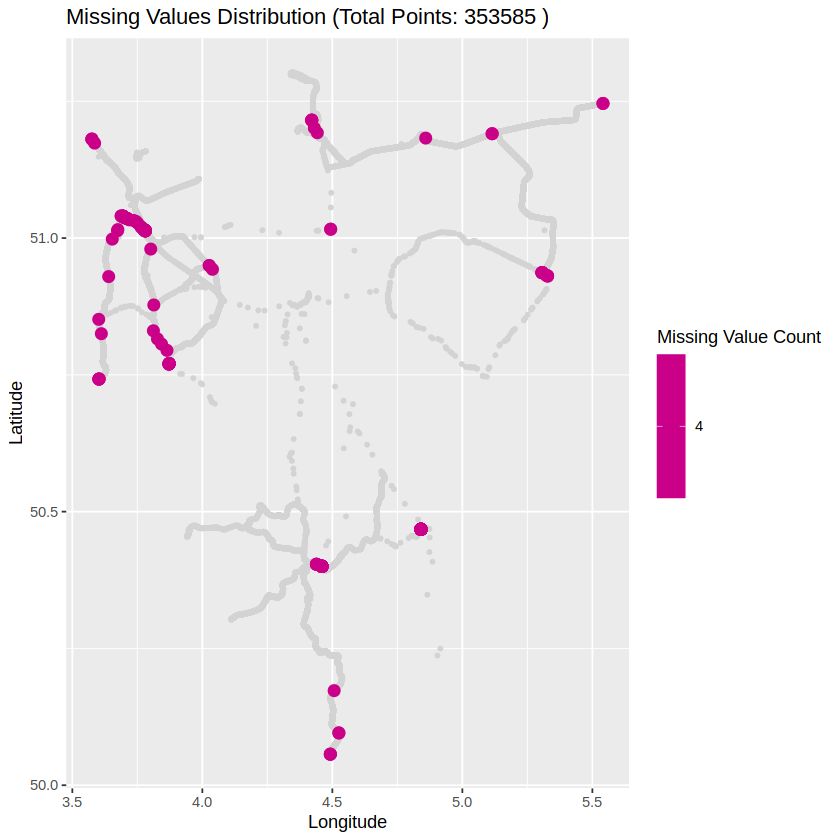

In [5]:
# Check for NA values in any of the specified columns
missing_values <- rowSums(is.na(data_df[, c("RS_E_InAirTemp_PC1", "RS_E_InAirTemp_PC2", "RS_E_OilPress_PC1", "RS_E_OilPress_PC2", "RS_E_RPM_PC1", "RS_E_RPM_PC2", "RS_E_WatTemp_PC1", "RS_E_WatTemp_PC2", "RS_T_OilTemp_PC1", "RS_T_OilTemp_PC2")]))

# Check if there are any missing values
if (sum(missing_values) > 0) {
  # Create a new data frame for missing values
  missing_data <- data.frame(lon = data_df$lon[missing_values > 0],
                             lat = data_df$lat[missing_values > 0],
                             missing_count = missing_values[missing_values > 0])

  # Create a plot
  ggplot(data_df, aes(x = lon, y = lat)) +
    geom_point(size = 1, color = "lightgray") +
    geom_point(data = missing_data, aes(color = missing_count), size = 3) +
    scale_color_gradient(low = "blue", high = "red") +
    labs(title = paste("Missing Values Distribution (Total Points:", nrow(data_df), ")"),
         x = "Longitude",
         y = "Latitude",
         color = "Missing Value Count")
      # Analyze the distribution of missing values

} else {
  # Create a plot without missing values
  library(ggplot2)
  ggplot(data_df, aes(x = lon, y = lat)) +
    geom_point(size = 1, color = "lightgray") +
    labs(title = paste("Total Points:", nrow(data_df)),
         x = "Longitude",
         y = "Latitude")
}


In [6]:
missing_analysis <- data.frame(feature = colnames(data_df)[7:16], 
                                 missing_count = colSums(is.na(data_df[, c("RS_E_InAirTemp_PC1", "RS_E_InAirTemp_PC2", "RS_E_OilPress_PC1", "RS_E_OilPress_PC2", "RS_E_RPM_PC1", "RS_E_RPM_PC2", "RS_E_WatTemp_PC1", "RS_E_WatTemp_PC2", "RS_T_OilTemp_PC1", "RS_T_OilTemp_PC2")])))
# Filter features with missing values
missing_analysis_filtered <- missing_analysis[missing_analysis$missing_count > 0, ]

# Print the filtered analysis
if (nrow(missing_analysis_filtered) > 0) {
  print("Analysis of Features with Missing Values:")
  print(missing_analysis_filtered)
} else {
  print("Aucune feature n'a de valeur manquante.")
}


[1] "Analysis of Features with Missing Values:"
                             feature missing_count
RS_E_InAirTemp_PC2 RS_E_OilPress_PC2           227
RS_E_OilPress_PC2       RS_E_RPM_PC2           227
RS_E_RPM_PC2        RS_E_WatTemp_PC2           227
RS_E_WatTemp_PC2    RS_T_OilTemp_PC2           227


In [7]:
# Sélectionner les colonnes pertinentes pour l'imputation
cols_capteur_1 <- c("RS_E_InAirTemp_PC1", "RS_E_OilPress_PC1", "RS_E_RPM_PC1", "RS_E_WatTemp_PC1", "RS_T_OilTemp_PC1")
cols_capteur_2 <- c("RS_E_InAirTemp_PC2", "RS_E_OilPress_PC2", "RS_E_RPM_PC2", "RS_E_WatTemp_PC2", "RS_T_OilTemp_PC2")

# Créer un dataframe pour l'imputation
impute_data <- data_df[, c(cols_capteur_1, cols_capteur_2)]

# Imputation des valeurs manquantes des capteurs 2 en utilisant les capteurs 1
for (col in cols_capteur_2) {
  impute_data[[col]][is.na(impute_data[[col]])] <- impute_data[[sub("_PC2", "_PC1", col)]][is.na(impute_data[[col]])]
}

# Créer une copie de data_df avec les valeurs manquantes imputées
data_df_impute <- data_df
data_df_impute[, cols_capteur_2] <- impute_data[, cols_capteur_2]

In [8]:
# Assuming data_df_WNA is your dataframe without NA values

# Detect and handle outliers using the IQR method
handle_outliers <- function(column) {
  Q1 <- quantile(column, 0.25)
  Q3 <- quantile(column, 0.75)
  IQR_value <- Q3 - Q1
  lower_limit <- Q1 - 1.5 * IQR_value
  upper_limit <- Q3 + 1.5 * IQR_value
  column[column < lower_limit] <- lower_limit
  column[column > upper_limit] <- upper_limit
  return(column)
}

# Apply outlier handling to relevant numeric columns
columns_to_handle_outliers <- c("lat", "lon", "RS_E_InAirTemp_PC1", "RS_E_InAirTemp_PC2", "RS_E_OilPress_PC1", "RS_E_OilPress_PC2", "RS_E_RPM_PC1", "RS_E_RPM_PC2", "RS_E_WatTemp_PC1", "RS_E_WatTemp_PC2", "RS_T_OilTemp_PC1", "RS_T_OilTemp_PC2")

for (col in columns_to_handle_outliers) {
  data_df_impute[, col] <- handle_outliers(data_df_impute[, col])
}

In [10]:
# Subset the data for selected variables
#selected_vars <- c("RS_E_InAirTemp_PC1", "RS_E_InAirTemp_PC2", "RS_E_OilPress_PC1","RS_E_OilPress_PC2", "RS_E_RPM_PC1", "RS_E_RPM_PC2", "RS_E_WatTemp_PC1", "RS_E_WatTemp_PC2", "RS_T_OilTemp_PC1", "RS_T_OilTemp_PC2")

# Subset the data
#subset_data <- data_df_impute[c("timestamps_UTC", selected_vars)]

# Melt the data for easier plotting
#melted_data <- reshape2::melt(subset_data, id.vars = "timestamps_UTC")

# Normalize the data
#melted_data$value <- scale(melted_data$value)

# Create a separate plot for each variable
#plots_list <- lapply(selected_vars, function(var) {
#  ggplot(melted_data[melted_data$variable == var, ], aes(x = timestamps_UTC, y = value)) +
#    geom_line() +
#    labs(title = paste(var),
#         x = "Timestamps",
#         y = "Variable Values") +
#    theme_minimal()
#})

#grid.arrange(grobs = plots_list)  # Adjust ncol as needed


In [11]:
# Check for NA values
na_count <- sum(is.na(data_df))

if (na_count > 0) {
  print(paste("There are", na_count, "NA values in the dataset. Removing them."))

  # Remove rows with NA values
  data_df_WNA <- na.omit(data_df)
}else {

  # Now, your data doesn't contain NA values, and you can proceed with further analysis or visualization.
  data_df_WNA <- data_df
}



[1] "There are 908 NA values in the dataset. Removing them."


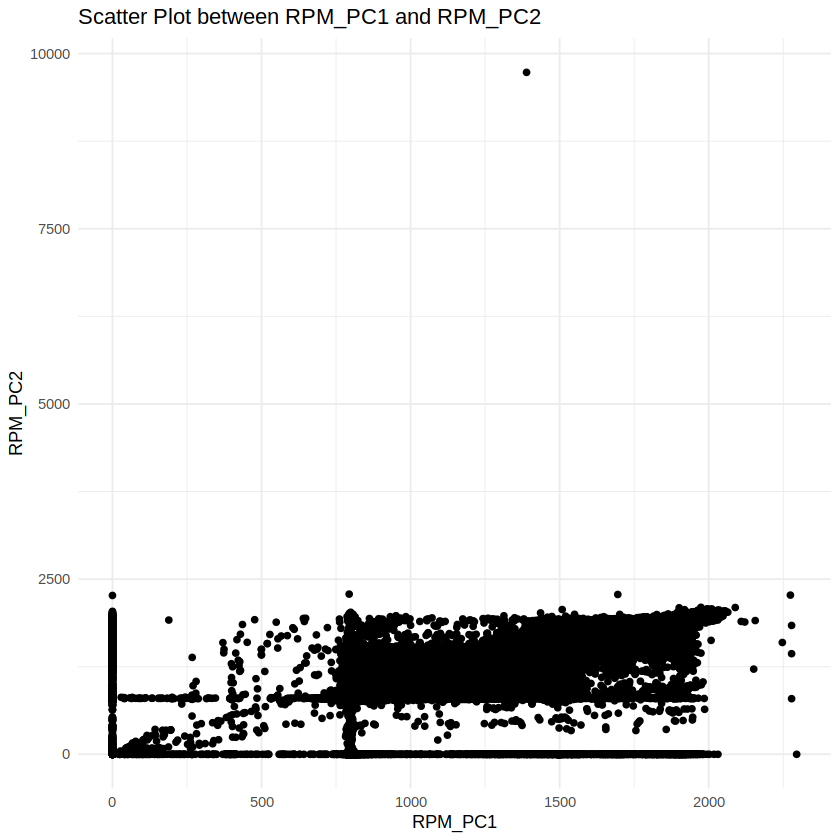

In [12]:
# Scatter plot
ggplot(data_df_WNA, aes(x = RS_E_RPM_PC1, y = RS_E_RPM_PC2)) +
  geom_point() +
  labs(title = "Scatter Plot between RPM_PC1 and RPM_PC2",
       x = "RPM_PC1",
       y = "RPM_PC2") +
  theme_minimal()


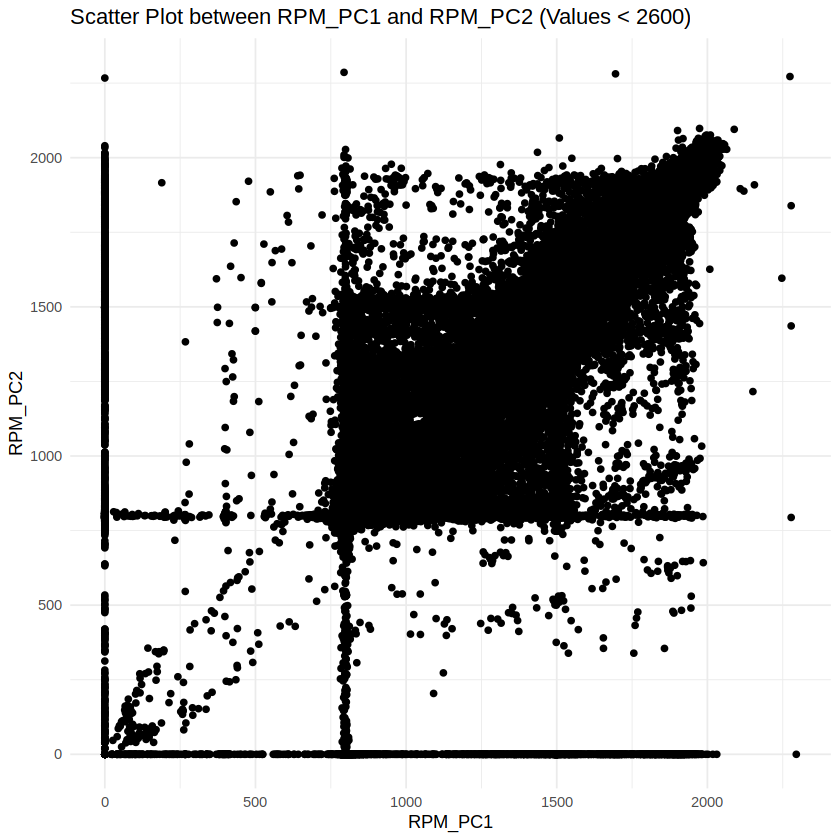

In [13]:
# Scatter plot
# Assuming data_df_WNA is your dataset with appropriate column names

# Filter data for values less than 2600 for both RPM_PC1 and RPM_PC2
filtered_data <- data_df_WNA[data_df_WNA$RS_E_RPM_PC1 < 2600 & data_df_WNA$RS_E_RPM_PC2 < 2600,]

# Scatter plot for the filtered data
ggplot(filtered_data, aes(x = RS_E_RPM_PC1, y = RS_E_RPM_PC2)) +
  geom_point() +
  labs(title = "Scatter Plot between RPM_PC1 and RPM_PC2 (Values < 2600)",
       x = "RPM_PC1",
       y = "RPM_PC2") +
  theme_minimal()


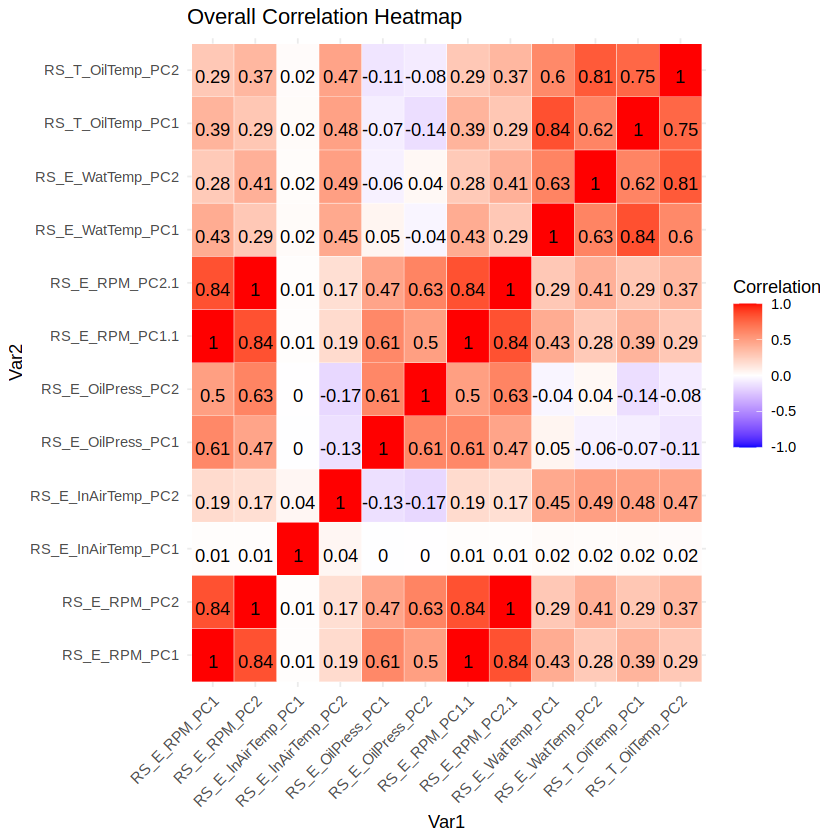

In [20]:
# Assuming data_df_WNA is your dataset with appropriate column names

# Select relevant columns for correlation analysis (excluding non-numeric and "Group" columns)
cor_columns <- c("RS_E_RPM_PC1","RS_E_RPM_PC2","RS_E_InAirTemp_PC1", "RS_E_InAirTemp_PC2", "RS_E_OilPress_PC1", "RS_E_OilPress_PC2", "RS_E_RPM_PC1", "RS_E_RPM_PC2", "RS_E_WatTemp_PC1", "RS_E_WatTemp_PC2", "RS_T_OilTemp_PC1", "RS_T_OilTemp_PC2")

# Select only numeric columns for correlation analysis
numeric_data <- data_df_WNA[, sapply(data_df_WNA, is.numeric)]

# Remove variables with zero standard deviation
numeric_data <- numeric_data[, sapply(numeric_data, sd) > 0]

# Calculate the correlation matrix
cor_matrix <- cor(numeric_data[, cor_columns])

# Plot a heatmap for the overall correlation matrix
library(ggplot2)
library(reshape2)

melted_cor_matrix <- melt(cor_matrix)
ggplot(melted_cor_matrix, aes(Var1, Var2, fill = value)) +
  geom_tile(color = "white") +
  scale_fill_gradient2(low = "blue", high = "red", mid = "white", midpoint = 0, limit = c(-1, 1), space = "Lab", name = "Correlation") +
  theme_minimal() +
  geom_text(aes(label = round(value, 2)), vjust = 1) +  # Add text labels with rounded correlation values
  theme(axis.text.x = element_text(angle = 45, hjust = 1)) +
  ggtitle("Overall Correlation Heatmap")


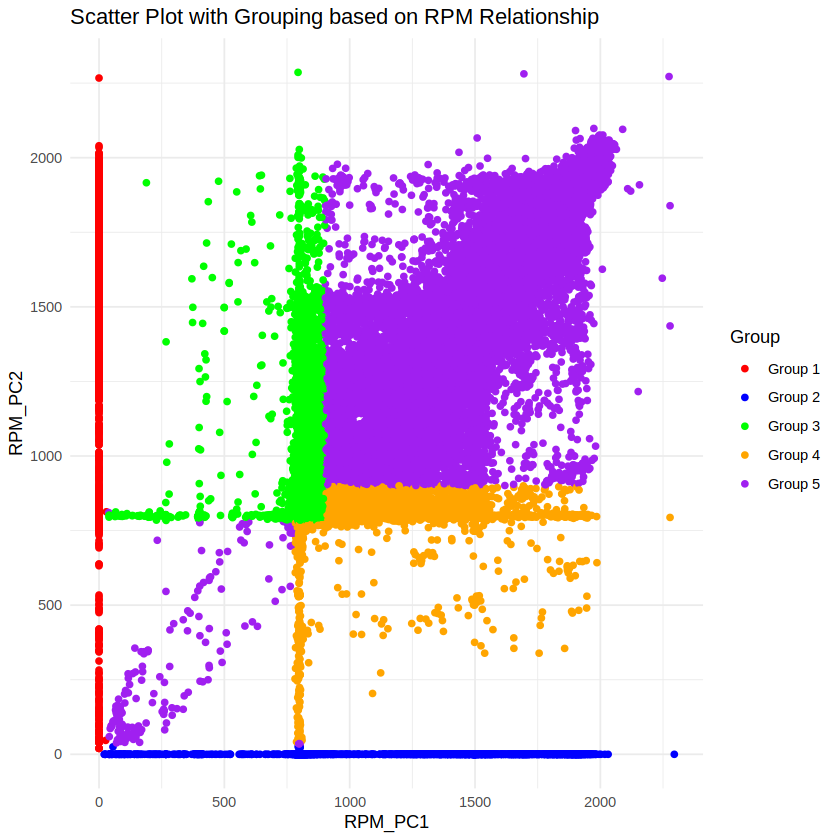

In [69]:
# Load necessary libraries
library(dplyr)
library(ggplot2)

# Assuming data_df_WNA is your dataset with appropriate column names

# Filtrer les données avec des valeurs en dessous de 2600 et exclure les lignes où les deux variables sont égales à 0
filtered_data <- data_df_WNA %>%
  filter(RS_E_RPM_PC1 < 2600 & RS_E_RPM_PC2 < 2600 & !(RS_E_RPM_PC1 == 0 & RS_E_RPM_PC2 == 0))

# Create a new variable 'Group' based on the specified conditions
filtered_data <- filtered_data %>%
  mutate(Group = case_when(
    between(RS_E_RPM_PC1, 0, 30) & RS_E_RPM_PC2 != 0 ~ "Group 1",
    RS_E_RPM_PC1 != 0 & between(RS_E_RPM_PC2, 0, 30) ~ "Group 2",
    between(RS_E_RPM_PC1, 40, 900) & RS_E_RPM_PC2 > 780 ~ "Group 3",
    between(RS_E_RPM_PC2, 40, 900) & RS_E_RPM_PC1 > 780 ~ "Group 4",
    TRUE ~ "Group 5"
  ))

# Define custom colors for each group
group_colors <- c("Group 1" = "red", "Group 2" = "blue", "Group 3" = "green", "Group 4" = "orange", "Group 5" = "purple")

# Scatter plot colored by the 'Group' variable
scatter_plot <- ggplot(filtered_data, aes(x = RS_E_RPM_PC1, y = RS_E_RPM_PC2, color = Group)) +
  geom_point() +
  scale_color_manual(values = group_colors) +  # Set custom colors
  labs(title = "Scatter Plot with Grouping based on RPM Relationship",
       x = "RPM_PC1",
       y = "RPM_PC2") +
  theme_minimal()

# Display the scatter plot
print(scatter_plot)

In [70]:
# Now, filter data for Group 5
group_5_data <- filtered_data %>%
  filter(Group == "Group 5") 

In [71]:
columns_to_handle_outliers_group5 <- c("lat", "lon", "RS_E_InAirTemp_PC1", "RS_E_InAirTemp_PC2", "RS_E_OilPress_PC1", "RS_E_OilPress_PC2", "RS_E_RPM_PC1", "RS_E_RPM_PC2", "RS_E_WatTemp_PC1", "RS_E_WatTemp_PC2", "RS_T_OilTemp_PC1", "RS_T_OilTemp_PC2")

# Filter data for Group 5
group_5_data <- filtered_data %>%
  filter(Group == "Group 5")

# Apply outlier handling to relevant numeric columns in Group 5
for (col in columns_to_handle_outliers_group5) {
  group_5_data[, col] <- handle_outliers(group_5_data[, col])
}


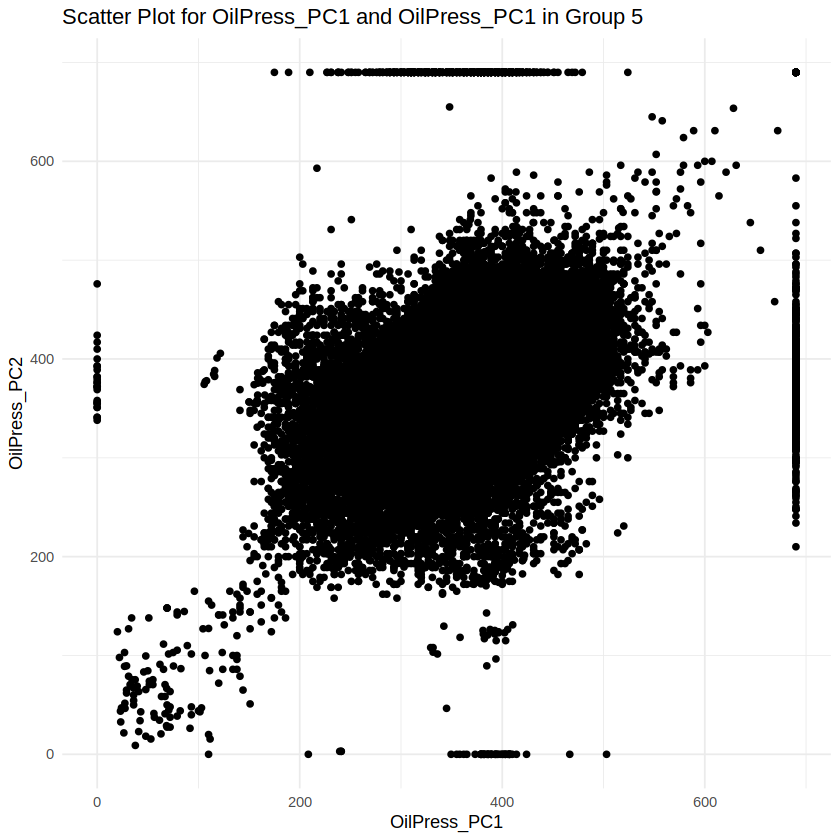

In [72]:
# Load necessary libraries
library(dplyr)
library(ggplot2)

# Define custom colors for each group
group_colors <- c("Group 1" = "red", "Group 2" = "blue", "Group 3" = "green", "Group 4" = "orange", "Group 5" = "purple")

# Scatter plot for RS_E_InAirTemp_PC1 and RS_E_InAirTemp_PC2 within Group 5
scatter_temp_plot <- ggplot(filtered_data %>% filter(Group == "Group 5"), 
                            aes(x = RS_E_OilPress_PC1, y = RS_E_OilPress_PC2)) +
  geom_point() +
  labs(title = "Scatter Plot for OilPress_PC1 and OilPress_PC1 in Group 5",
       x = "OilPress_PC1",
       y = "OilPress_PC2") +
  theme_minimal()

# Display the scatter plot for temperature variables within Group 5
print(scatter_temp_plot)


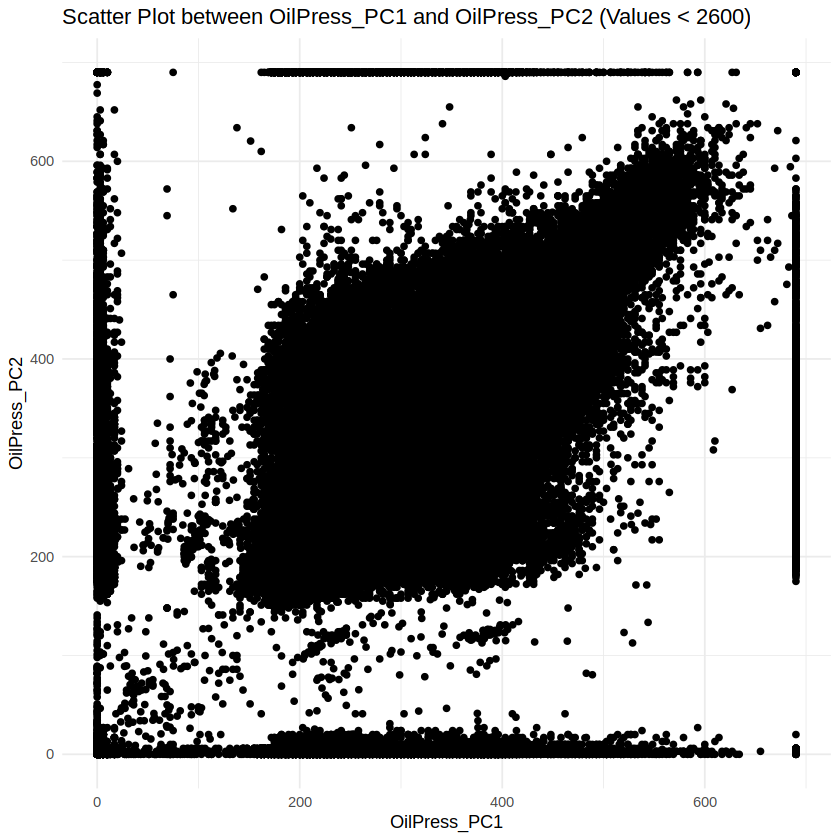

In [73]:
# Scatter plot
# Assuming data_df_WNA is your dataset with appropriate column names

# Scatter plot for the filtered data
ggplot(data_df_WNA, aes(x = RS_E_OilPress_PC1, y = RS_E_OilPress_PC2)) +
  geom_point() +
  labs(title = "Scatter Plot between OilPress_PC1 and OilPress_PC2 (Values < 2600)",
       x = "OilPress_PC1",
       y = "OilPress_PC2") +
  theme_minimal()